In [1]:
# ------------------------------------------
# IMPORT OF MODULES 
# ------------------------------------------

# Standard library
import sys 
import os
import datetime
from pathlib import Path

# Third party
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Local
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))) # This construct was reworked with the assistance of AI (DeepSeek) 

from data_import import RawData
raw_data = RawData()

from data_handling import RefinedData
ref_data = RefinedData()

from utils import VisualTable
pretty_table = VisualTable()

from analysis import AnalysedData
analysed_data = AnalysedData()

from graphs import Graphs, PredictiveGraphs
graphic_data = Graphs()
predictive_graphs = PredictiveGraphs()

from predictive_analysis import WeatherAnalyser
predicted_data = WeatherAnalyser()

# ------------------------------------------
# GLOBAL SETTINGS & TOGGLES
# ------------------------------------------

# -- Toggles for showing more or less info in terminal
SHOW_ALL_TABLES: bool = False # Shows full tables at every step if True, excluding them if False
SHOW_ALL_GRAPHS: bool = False  # Shows all graphs at every step if True, limits to the bare minimum if False
SHOW_ALL_INFO: bool = False # Shows all info at every step if True, limits to the bare minimum if False
SAVE_FILE: bool = False # Save various dataframes as files in the data folder
    
# ------------------------------------------
# DATA SOURCE CONFIGURATIONS
# ------------------------------------------

# -- Frost API Settings for retrieving weather data 
    # - the first is for the historical data (training data)
    # - the second is for the the more recent data (test data)

FROST_API_CONFIG = {
    'station_id': 'SN68860',  # Weather station ID, can be multiple stations separated by a comma - 'SN68860' is Voll weatherstation
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)', # The measurements to include in the dataset, here: temperature, precipitation, and wind speed
    'time_range': '2003-08-01/2018-08-01',# The stretch of time to fetch weather data from
    'resolution': 'P1D',   # The level of granularity in the weather data. P1D is once per day. P1H is once per hour.
    'show_info': SHOW_ALL_INFO
}

yesterday = (pd.Timestamp.utcnow() - pd.Timedelta(days=1)).strftime('%Y-%m-%d') # This construct was generate by AI (DeepSeek)
time_range = '2018-01-01/' + yesterday

FROST_API_CONFIG_TEST = {
    'station_id': 'SN68860',  # Weather station ID, can be multiple stations separated by a comma - 'SN68860' is Voll weatherstation
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)', # The measurements to include in the dataset, here: temperautre, precipitation, and wind speed
    'time_range': time_range, # The stretch of time to fetch weather data from, up until today
    'resolution': 'P1D',   # The level of granularity in the weather data. P1D is once per day. P1H is once per hour.
    'show_info': SHOW_ALL_INFO
}

#LAT, LON = 63.419, 10.395 # Weather station lat/lon for fetching the weather forecast

# -- Variables for NILU file import and analysis 
# File paths
FILE_PATH: Path = Path('../data/luftkvalitet_trondheim_2003-2018.csv') # Using path/PathLib was suggested by AI (DeepSeek)
FILE_PATH_TEST: Path = Path('../data/luftkvalitet_trondheim_2018-2024.csv')

# ------------------------------------------
# ANALYSIS PARAMETERS
# ------------------------------------------

# Analysis threshold
UPTIME_THRESHOLD = 95 # Minimum uptime (%) for valid air quality data

# -- Variables for analysis and graphing
# The number of standard deviations that defines an outlier
SD_MOD = 3 # A lower number gives a higher number of outliers, recommended range is 2-3

# Y-axis limits and alignment for weather plots: [temp (C), wind (m/s), precip (mm)]
WEATHER_Y_LIMS = [
    (-20, 30), # Temperature
    (0, 20), # Wind
    (0, 100) # Precipitation
    ] 

# ------------------------------------------
# DATA COLUMNS & FEATURES
# ------------------------------------------

# Weather and pollutant variables t
POLLUTANTS = ['CO', 'NO', 'NO2', 'NOx', 'PM10', 'PM2.5'] # The columns that can be found in the air pollutant data
POLLUTANT_VARS = ['CO', 'NO', 'NO2', 'PM10', 'PM2.5'] # Excluding NOx, an aggregate of NO and NO2
WEATHER_VARS = ['temperature (C)', 'wind_speed (m/s)', 'precipitation (mm)'] # The columns that can be found in the weather data

# -- Variables for predictive analysis
'''
Available features:
    - Datetime: ['Date']
    - Weather data variables: ['temperature (C)', 'wind_speed (m/s)', 'precipitation (mm)']
    - Pollutant data variables: ['CO', 'NO', 'NO2', 'PM10', 'PM2.5'] 
    - Variations of dates/dateime: ['DayOfYear', 'DayOfYear_sin', 'DayOfYear_cos']
    - Seasonal and weekend effects: ['Weekend', 'Season', 'weekend_effect'] 
    - Weather variable interactions: ['temp_wind_interaction', 'temp_precip_interaction', 'precip_wind_interaction', 'temperature_wind_speed_interaction', 'temperature_precipitation_interaction', 'wind_speed_precipitation_interaction'] 
    - Smoothed weather variables: ['rolling_temperature_7', 'rolling_wind_speed_7', 'rolling_precipitation_7']

Available pollution specific lag features:
    - NO lag features: ['NO_lag_1', 'NO_lag_3', 'NO_lag_7', 'NO_lag_30', 'NO_lag_14', 'rolling_NO_7']
    - NO2 lag features: ['NO2_lag_1', 'NO2_lag_3', 'NO2_lag_7', 'NO2_lag_30', 'NO2_lag_14', 'rolling_NO2_7']
    - PM2.5 lag features: ['PM2.5_lag_1', 'PM2.5_lag_3', 'PM2.5_lag_7', 'PM2.5_lag_30', 'PM2.5_lag_14', 'rolling_PM2.5_7']
    - PM10 lag features: ['PM10_lag_1', 'PM10_lag_3', 'PM10_lag_7', 'PM10_lag_30', 'PM10_lag_14', 'rolling_PM10_7']
'''

# Default features were chosen based on feature importance - the levels are presented in graphs in the predictive analysis section
# The most important feature for all was the rolling 7 day smoothed baseline of the pollutant itself

CO_FEATURES = [                                          
    'wind_speed (m/s)',    # Transport/dispersion 
    'CO_lag_1',            # Immediate persistence 
    'CO_lag_7',            # Weekly pattern  
    'CO_lag_14',           # Biweekly pattern 
    'rolling_CO_7',        # Smoothed baseline  
    'weekend_effect'       # Traffic/industrial variation  
]

NO_FEATURES = [
    'wind_speed (m/s)',    # Transport/dispersion     
    'NO_lag_1',            # Immediate persistence    
    'NO_lag_7',            # Weekly pattern    
    'NO_lag_14',           # Biweekly pattern   
    'rolling_NO_7',        # Smoothed baseline      
    'weekend_effect'       # Traffic/industrial variation 
]

NO2_FEATURES = [
    'wind_speed (m/s)',   # Transport/dispersion control  
    'NO2_lag_1',          # Immediate persistence    
    'NO2_lag_7',          # Weekly pattern  
    'NO2_lag_14',         # Biweekly pattern  
    'rolling_NO2_7',      # Smoothed baseline    
    'weekend_effect'      # Traffic/industrial variation 
]

PM25_FEATURES = [
    'wind_speed (m/s)',          # Core driver  
    'PM2.5_lag_1',               # Immediate persistence 
    'PM2.5_lag_7',               # Weekly pattern    
    'rolling_wind_speed_7',      # Smoothed wind       
    'precip_wind_interaction',   # Rain-wind synergy    
    'wind_speed (m/s)_lag_1',    # Valuable lag       
    'rolling_PM2.5_7'            # Smoothed baseline    
]

PM10_FEATURES = [
    'wind_speed (m/s)',          # Core driver       
    'PM10_lag_1',                # Immediate persistence   
    'PM10_lag_3',                # Short term persistence   
    'PM10_lag_7',                # Weekly pattern         
    'rolling_PM10_7',            # Smoothed baseline      
    'precip_wind_interaction',   # Rain-wind synergy   
    'rolling_wind_speed_7'       # Smoothed wind         
]

CUT_OFF_DATE = '2018-01-01' # The date where the training and test data is split
# Note: For this project the cut-off date for Carbon monoxide has been hard coded due to limited date-ranges

In [2]:
# ------------------------------------------
# WEATHER DATA - IMPORT AND PROCESSING
# ------------------------------------------

def process_and_display_weather(df, description=""):
    """Helper function to process and display weather data"""
    if df is None or df.empty:
        print(f"Failed to fetch {description}weather data")
        return None
    
    # Report missing values
    missing_report = ref_data.missing_data(df, strategy='report')
    if missing_report is not None and not missing_report.empty and SHOW_ALL_TABLES:
        print(f"\nMissing datapoints in {description}weather data:")
        pretty_table.pretty_data(missing_report)
    
    # Fill missing values
    filled_df = ref_data.missing_data(df, strategy='fill', fill_value=np.nan) # The use of a strategy variable was suggested by AI (DeepSeek)
    if filled_df is not None:
        df = filled_df
    
    if SHOW_ALL_TABLES:
        print(f'\n{description.capitalize()}weather data:')
        pretty_table.pretty_data(df)
    
    return df

# --- Training Data ---
df_weather = raw_data.get_met(**FROST_API_CONFIG)
df_weather = process_and_display_weather(df_weather, "training ")

# --- Test Data ---
df_weather_test = raw_data.get_met(**FROST_API_CONFIG_TEST)
df_weather_test = process_and_display_weather(df_weather_test, "test ")

# --- Forecast Data ---
df_forecast = raw_data.get_forecast(station_id="SN68860")
if df_forecast is None:
    print("Failed to fetch forecast data.")
else:
    if SHOW_ALL_TABLES:
        print('\nThe weather forecast:')
        pretty_table.pretty_data(df_forecast)

In [3]:
# ------------------------------------------
# AIR QUALITY DATA - IMPORT AND PROCESSING
# ------------------------------------------

def process_air_quality(df, description=""):
    """Process and display air quality data"""
    if df is None or df.empty:
        print(f"Failed to fetch {description}air quality data or data is empty")
        return None
    
    # Check and report missing values
    missing_report = ref_data.missing_data(df, strategy='report')
    if missing_report is not None and not missing_report.empty and SHOW_ALL_TABLES:
        print(f"\nMissing datapoints in {description}air quality data:")
        pretty_table.pretty_data(missing_report)
    
    # Fill missing values
    filled_df = ref_data.missing_data(df, strategy='fill', fill_value=np.nan)
    if filled_df is not None:
        df = filled_df
    
    if SHOW_ALL_TABLES:
        print(f'\n{description.capitalize()}air pollution data (pollutants in µg/m³):')
        pretty_table.pretty_data(df)
    
    return df

# --- Training Data ---
df_quality = raw_data.get_nilu(UPTIME_THRESHOLD, FILE_PATH, SHOW_ALL_INFO)
df_quality = process_air_quality(df_quality, "training ")

# --- Test Data ---
df_quality_test = raw_data.get_nilu(UPTIME_THRESHOLD, FILE_PATH_TEST, SHOW_ALL_INFO)
df_quality_test = process_air_quality(df_quality_test, "test ")


Standard deviation of weather data



Total average (mean) of weather data



Standard deviation of air pollutant data



Total average (mean) of air pollutant data


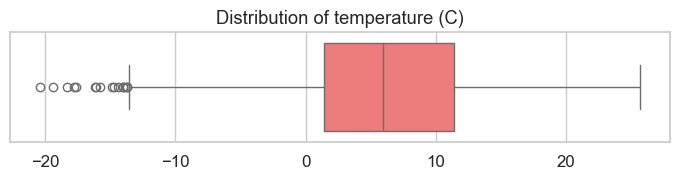

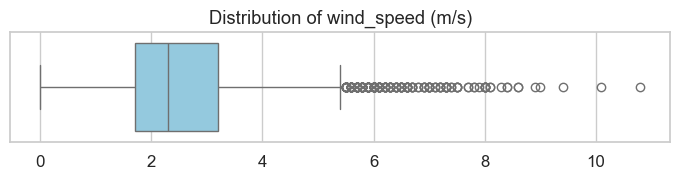

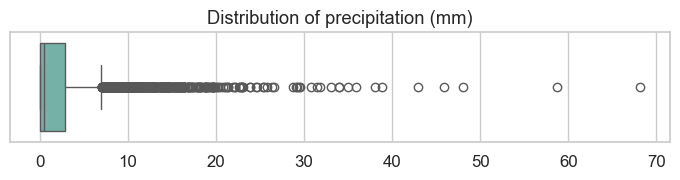

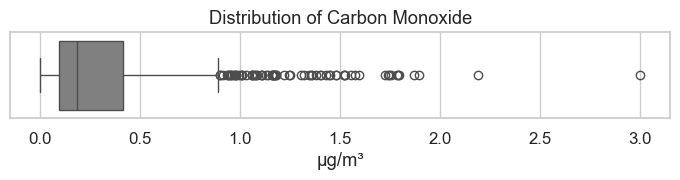

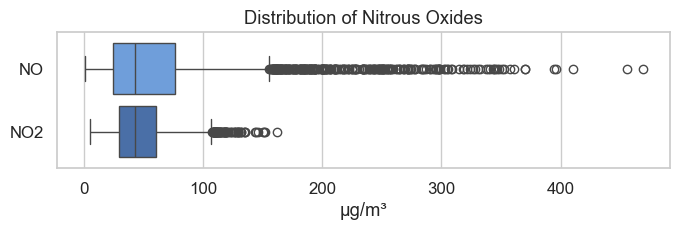

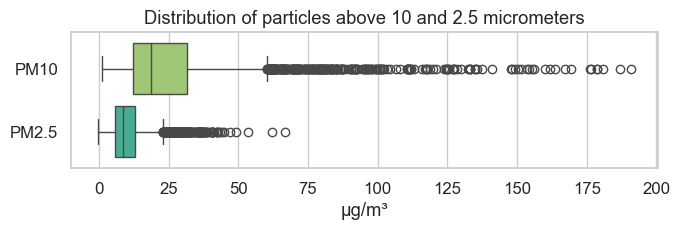

In [4]:
# ------------------------------------------
# DATA AND PATTERN ANALYSIS
# ------------------------------------------

# The helper functions were suggested by AI (DeepSeek) and reworked by the developer

# --- Helper Functions ---
def display_required_table(data, description):
    """Helper to display tables that should always be shown"""
    print(f'\n{description}')
    pretty_table.pretty_data(data)

def display_optional_table(data, description):
    """Helper to display tables based on SHOW_ALL_TABLES setting""" 
    if SHOW_ALL_TABLES:
        print(f'\n{description}')
        pretty_table.pretty_data(data)

# --- Statistical Analysis ---

# Weather statistics (always shown)
weather_standard_deviation = analysed_data.standard_deviation(df_weather, WEATHER_VARS)
display_required_table(weather_standard_deviation, 'Standard deviation of weather data')

weather_average = analysed_data.total_average(df_weather, WEATHER_VARS)
display_required_table(weather_average, 'Total average (mean) of weather data')

# Pollution statistics (always shown)
pollutants_standard_deviation = analysed_data.standard_deviation(df_quality, POLLUTANTS)
display_required_table(pollutants_standard_deviation, 'Standard deviation of air pollutant data')

pollution_average = analysed_data.total_average(df_quality, POLLUTANTS)
display_required_table(pollution_average, 'Total average (mean) of air pollutant data')

# --- Outlier Detection --- 
weather_outliers, weather_x_outliers = analysed_data.outliers(
    df_weather, WEATHER_VARS, weather_standard_deviation, weather_average, SD_MOD)
display_optional_table(weather_outliers, 'Outliers from weather data')
display_optional_table(weather_x_outliers, 'Weather data without outliers')

pollution_outliers, pollution_x_outliers = analysed_data.outliers(
    df_quality, POLLUTANTS, pollutants_standard_deviation, pollution_average, SD_MOD)
display_optional_table(pollution_outliers, 'Outliers from pollutant data')
display_optional_table(pollution_x_outliers, 'Pollutant data without outliers')

# --- Temporal Averages --- 
df_average_weather = analysed_data.averages(weather_x_outliers, WEATHER_VARS)
display_optional_table(df_average_weather, 'Weekly averages for weather data')

df_average_pollutants = analysed_data.averages(pollution_x_outliers, POLLUTANTS)
display_optional_table(df_average_pollutants, 'Weekly averages for air pollutants (µg/m³)')

# Box plots of weather variables
colors = ['#FF6B6B','skyblue','#6BBBAE' ]
for column, color in zip(WEATHER_VARS, colors):
    analysed_data.box_plots(
        df = df_weather,
        columns = [column],
        color = color,
        figsize = [7, 2]
    )

# Box plot of Carbon monoxide
analysed_data.box_plots(
    df = df_quality,
    columns = 'CO',
    color = 'grey',
    figsize = (7, 2),
    title = 'Distribution of Carbon Monoxide',
    x_label = 'µg/m³'
)

# Box plot of Nitrous Oxides
analysed_data.box_plots(
    df = df_quality,
    columns = ['NO', 'NO2'],
    color = ['#5D9CEC', '#3A6CB7'],
    figsize = (7,2.5),
    title = 'Distribution of Nitrous Oxides',
    x_label = 'µg/m³'
)

# Box plot of Particles
analysed_data.box_plots(
    df = df_quality,
    columns = ['PM10', 'PM2.5'],
    color = ['#A0D468', '#37BC9B'],
    figsize = (7,2.5),
    title = 'Distribution of particles above 10 and 2.5 micrometers',
    x_label = 'µg/m³'
)

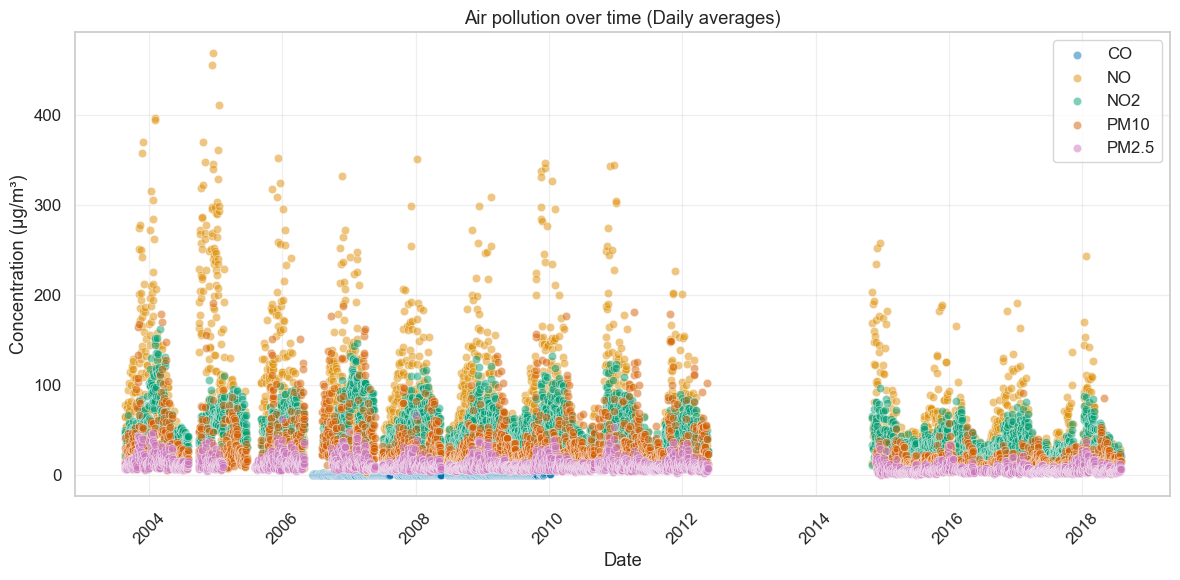

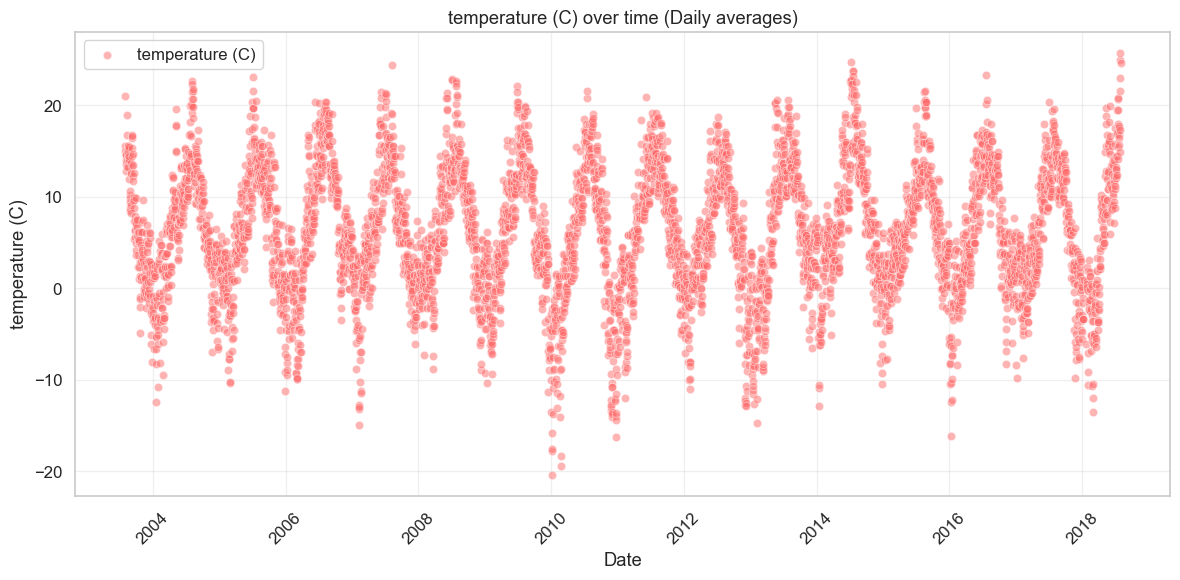

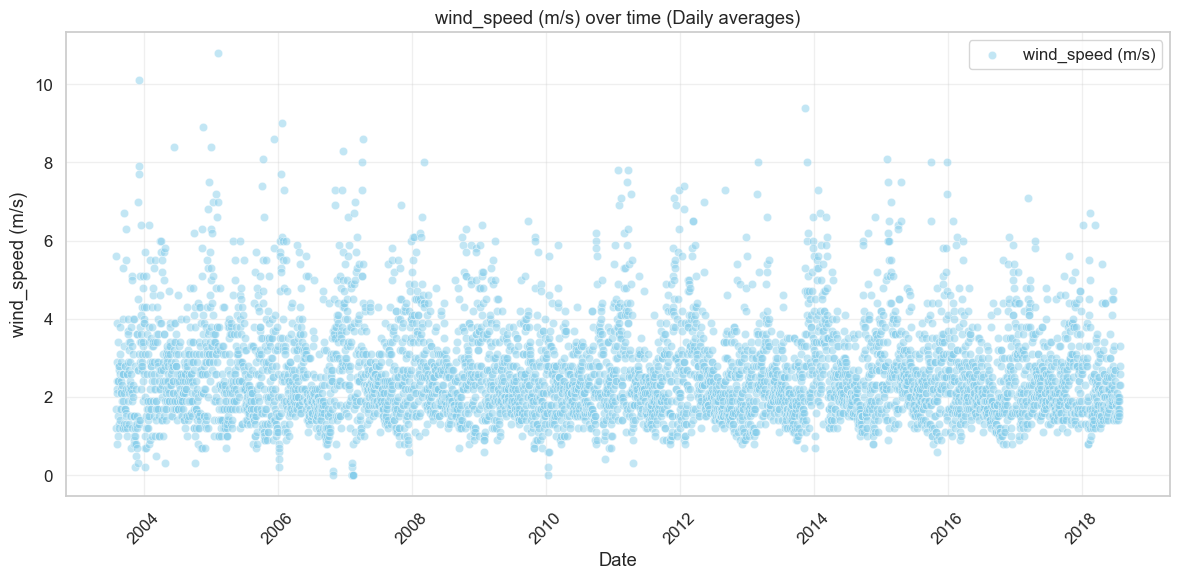

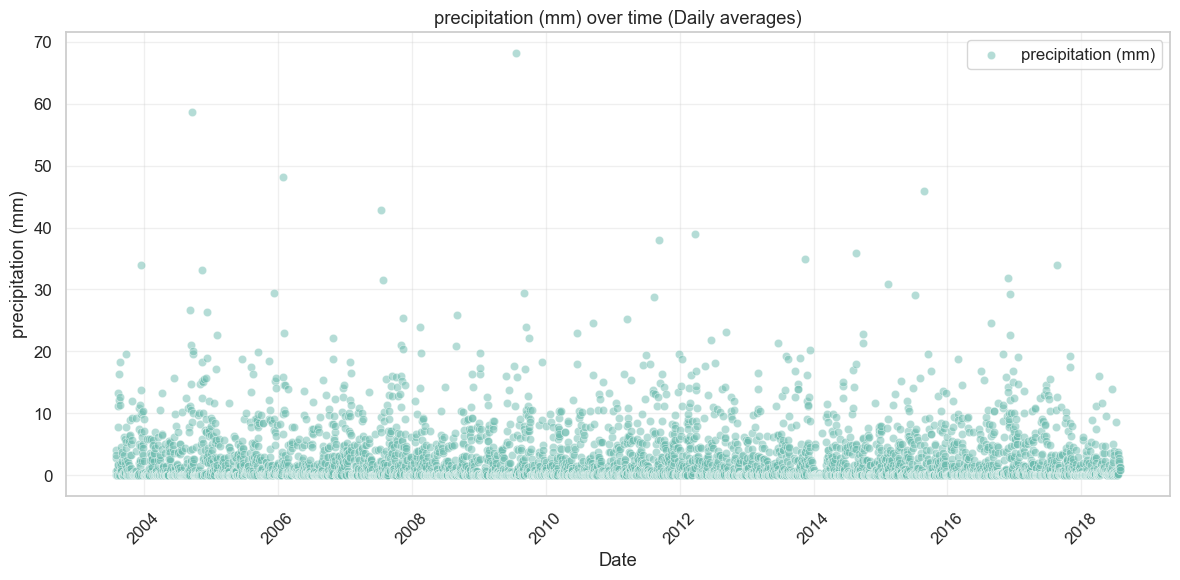

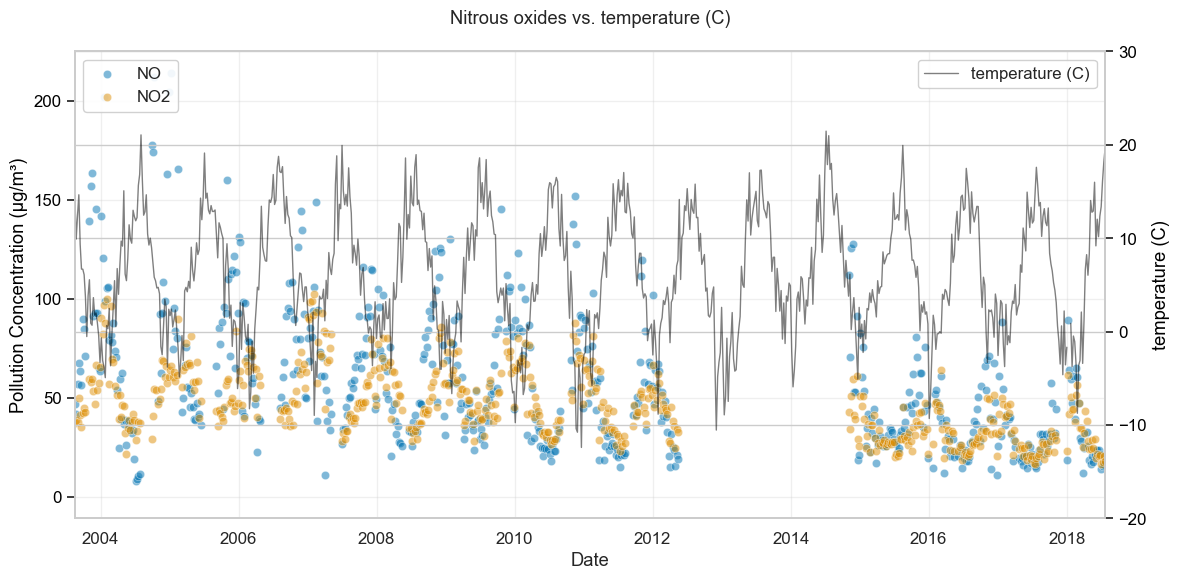

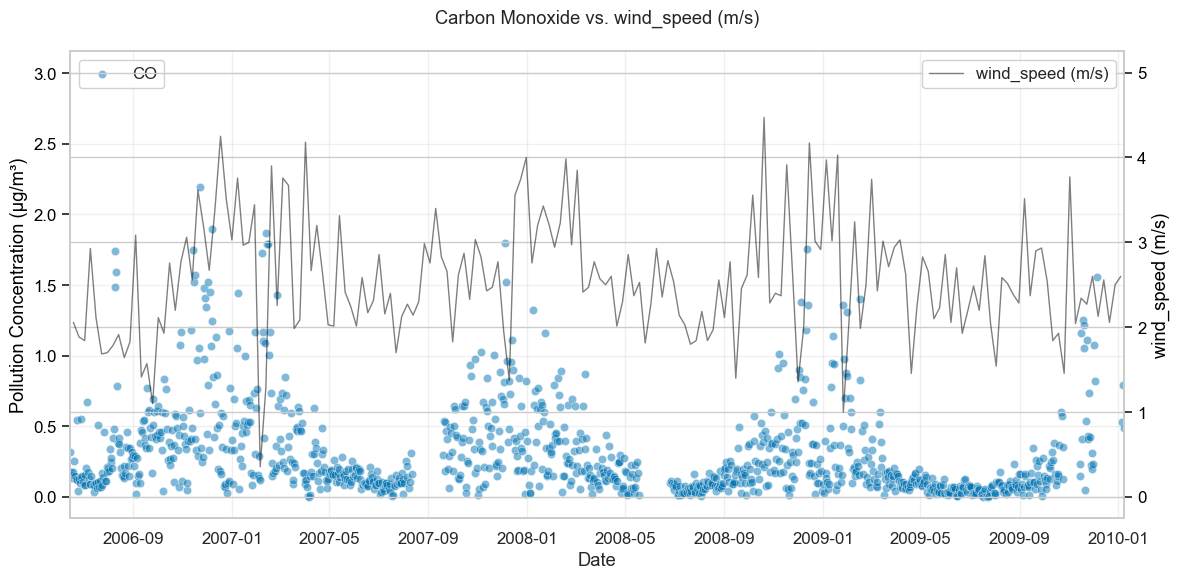

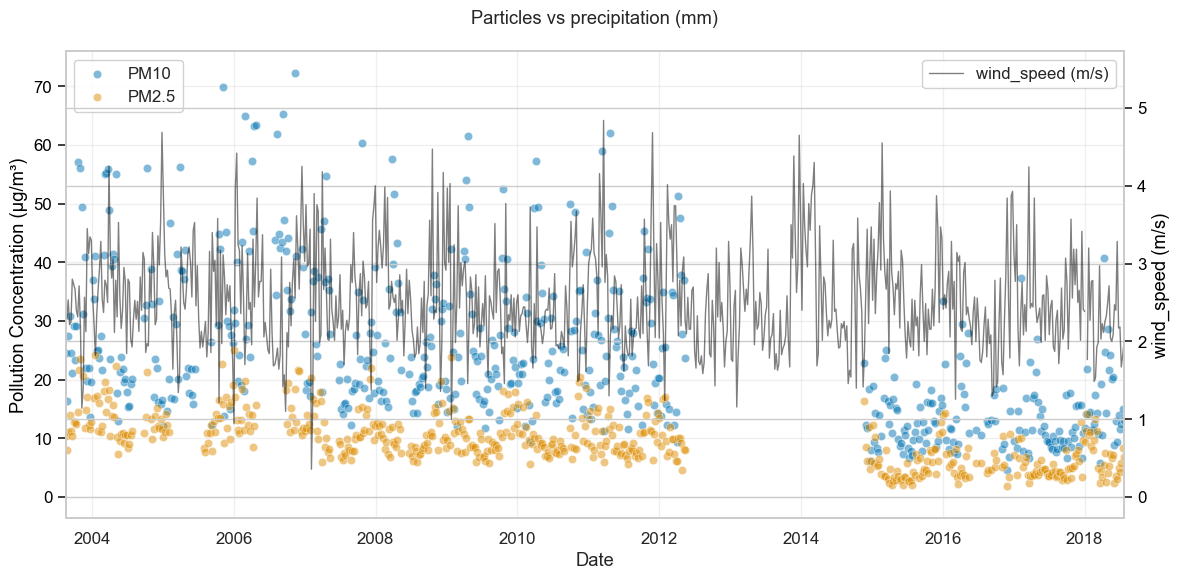

In [5]:
# ------------------------------------------
# DATA VISUALISATION AND GRAPHING
# ------------------------------------------

# --- Pollution Time Series ---

# Main daily average pollution plot (always shown)
graphic_data.dot_graph(
    df_quality, 
    POLLUTANT_VARS, 
    'Air pollution over time (Daily averages)', 
    'Date', 
    'Concentration (µg/m³)'
)

# Optional daily average plot of a selection of pollutants
if SHOW_ALL_GRAPHS is True:
    # Creating a scattergraph of Nitrous Oxides
    graphic_data.dot_graph(
        df_quality, 
        ['NO', 'NO2'], 
        'Nitrous oxides over time (Daily averages)', 
        'Date', 
        'Concentration (µg/m³)'
    )

    # Creating a scattergraph of Carbon monoxide
    graphic_data.dot_graph(
        df_quality, 
        ['CO'], 
        'Carbon monoxide over time (Daily averages)', 
        'Date', 
        'Concentration (µg/m³)'
    )

    # Creating a scattergraph of particles over time
    graphic_data.dot_graph(
        df_quality, 
        ['PM2.5', 'PM10'], 
        'Particles over time (Daily averages)', 
        'Date', 
        'Concentration (µg/m³)'
    )

    # Scattergraph for weekly averages of air quality data
    graphic_data.dot_graph(
        df_average_pollutants, 
        POLLUTANT_VARS, 
        'Air pollution over time (weekly averages)', 
        'Date', 
        'Concentration (µg/m³)'
    )

# --- Weather Time Series --- (always shown)
colors = ['#FF6B6B','skyblue','#6BBBAE' ]
for column, color in zip(WEATHER_VARS, colors):
    graphic_data.dot_graph(
        df=df_weather,
        columns=[column],  
        title=f'{column} over time (Daily averages)', 
        x_axis='Date',
        y_axis=column,
        color=color  
    )

# Optional plots of average weekly data for weather variables
if SHOW_ALL_GRAPHS is True:
    # Creating a scattergraph for each of the the weather data variables for weekly averages
    for column in WEATHER_VARS:
        graphic_data.dot_graph(
            df=df_average_weather,
            columns=[column],
            title=f'{column} over time (Weekly averages)', 
            x_axis='Date',
            y_axis=column  
        )

# --- Comparative Plots ---

# Creating a comparative graph of Nitrous oxides vs temperature (always shown)
graphic_data.comparative_graph(
    df=df_average_pollutants,
    columns=['NO', 'NO2'], 
    df_predictor=df_average_weather,
    predictor='temperature (C)',
    title=f'Nitrous oxides vs. temperature (C)',  
    x_axis='Date',
    y_axis='Pollution Concentration (µg/m³)',
    y_lims=(-20,30),
    zero_align=False
)

# Optional comparative graphs
if SHOW_ALL_GRAPHS is True:
    # Creating a comparative graph of Carbon Monoxide vs temperature
    graphic_data.comparative_graph(
        df=df_quality,
        columns=['CO'], 
        df_predictor=df_average_weather,
        predictor='temperature (C)',
        title=f'Carbon Monoxide vs. temperature (C)',  
        x_axis='Date',
        y_axis='Pollution Concentration (µg/m³)',
        y_lims=(-20,30),
        zero_align=False
    )

    # Creating a comparative graph of Nitrous oxides vs wind speed
    graphic_data.comparative_graph(
        df=df_average_pollutants,
        columns=['NO', 'NO2'], 
        df_predictor=df_average_weather,
        predictor='wind_speed (m/s)',
        title=f'Nitrous oxides vs. wind_speed (m/s)',  
        x_axis='Date',
        y_axis='Pollution Concentration (µg/m³)',
        y_lims=(0,5.5),
        zero_align=True
    )

# Creating a comparative graph of Carbon Monoxide vs wind speed (always shown)
graphic_data.comparative_graph(
    df=df_quality,
    columns=['CO'], 
    df_predictor=df_average_weather,
    predictor='wind_speed (m/s)',
    title=f'Carbon Monoxide vs. wind_speed (m/s)',  
    x_axis='Date',
    y_axis='Pollution Concentration (µg/m³)',
    y_lims=(0,5.5),
    zero_align=True
)

# Creating a comparative graph of particles vs precipitation (always shown)
graphic_data.comparative_graph(
    df=df_average_pollutants,
    columns=['PM10', 'PM2.5'], 
    df_predictor=df_average_weather,
    predictor='wind_speed (m/s)',
    title=f'Particles vs precipitation (mm)',  
    x_axis='Date',
    y_axis='Pollution Concentration (µg/m³)',
    y_lims=(0,6),
    zero_align=True
)


In [6]:
# ------------------------------------------
# PREDICTIVE ANALYSIS: MODEL DEVELOPMENT
# ------------------------------------------

# -- Creating simplistic regressive models for weather variables -- 
if SHOW_ALL_INFO:
    print(f'\n--- *** ---\n{"Merging and preparing weather and pollution data for modelling and training"}\n--- *** ---\n', flush=True)

# Load training data for simplistic weather pattern models
weather_train = predicted_data.load_weather_data(
    df_weather[pd.to_datetime(df_weather['Date']) < pd.to_datetime(CUT_OFF_DATE)],
    WEATHER_VARS,
    SHOW_ALL_INFO
)

weather_test = predicted_data.load_weather_data(
    df_weather_test[df_weather_test['Date'] >= CUT_OFF_DATE],
    WEATHER_VARS,
    SHOW_ALL_INFO
)

# Create simplistic models for all weather variables
model_temp = predicted_data.create_model(degree=6)
predicted_data.safe_fit(
    model_temp,
    weather_train[['DayOfYear']],
    weather_train['temperature (C)']
)

model_precip = predicted_data.create_model(degree=4)
predicted_data.safe_fit(
    model_precip,
    weather_train[['DayOfYear']],
    weather_train['precipitation (mm)']
)

model_wind = predicted_data.create_model(degree=5)
predicted_data.safe_fit(
    model_wind,
    weather_train[['DayOfYear']],
    weather_train['wind_speed (m/s)']
)

# -- Creating more complex models for pollution variables with predictors -- 

# Load training data (up to Dec 2017)
merged_data = predicted_data.load_and_merge_data(
    weather_x_outliers[weather_x_outliers['Date'] < CUT_OFF_DATE],
    pollution_x_outliers[pollution_x_outliers['Date'] < CUT_OFF_DATE],
    WEATHER_VARS,
    POLLUTANT_VARS, 
    SHOW_ALL_INFO,
    'train'
)

# Load test data (Jan 2018 onward)
merged_data_test = predicted_data.load_and_merge_data(
    df_weather_test[df_weather_test['Date'] >= CUT_OFF_DATE],
    df_quality_test[df_quality_test['Date'] >= CUT_OFF_DATE],
    WEATHER_VARS,
    POLLUTANT_VARS,
    SHOW_ALL_INFO,
    'test'
)

# Load training data for carbon monoxide
merged_co_data = predicted_data.load_and_merge_data(
    weather_x_outliers[weather_x_outliers['Date'] < '2008-07-01'],
    pollution_x_outliers[pollution_x_outliers['Date'] < '2008-07-01'],
    WEATHER_VARS,
    POLLUTANT_VARS,
    SHOW_ALL_INFO,
    'train'
)

# Load test data for carbon monoxide
merged_co_data_test = predicted_data.load_and_merge_data(
    weather_x_outliers[weather_x_outliers['Date'] > '2008-07-01'],
    pollution_x_outliers[pollution_x_outliers['Date'] > '2008-07-01'],
    WEATHER_VARS,
    POLLUTANT_VARS,
    SHOW_ALL_INFO,
    'test'
)

# Function to run a target pollutant through creating a model and testing it, with multiple features
def run_full_analysis(target, features, train_data, test_data):

    """
    Trains and evaluates a model for a target pollutant.
    
    Args:
        target (str): Pollutant name (e.g., 'NO2')
        features (list): Feature columns for the model
        train_data (pd.DataFrame): Training data
        test_data (pd.DataFrame): Test data
        
    Returns:
        tuple: (model, predictions, filtered_test_data)
            model: Trained RandomForestRegressor
            predictions: Model predictions on test data
            filtered_test_data: Test data with predictions/errors
    """

    if train_data.empty or test_data.empty:
        raise ValueError("Train/test data cannot be empty!")
    
    if not isinstance(features, list):
        print(f"⚠️ Features should be a list, got {type(features)}")
        features = list(features)  
    
    # The following block of code was generated by AI
        # Purpose: Setting up error handling in this function for recurring debugging while coding
        # AI Tool: DeepSeek

    # Check for missing features
    missing = [f for f in features if f not in train_data.columns]
    if missing:
        available = [f for f in features if f in train_data.columns]
        similar = [col for col in train_data.columns 
                  if any(f in col for f in missing)]
        
        print(f"⚠️ Missing features: {missing}")
        print(f"✅ Available features: {available}")
        print(f"🔍 Similar existing columns: {similar}")
        raise ValueError("Fix features before proceeding")

    # Train model and evaluate
    model = predicted_data.train_model(train_data, target, features)
    predictions, filtered_test_data, mse, r2 = predicted_data.evaluate_model(model, test_data, target, features, train_data)

    # Add error calculation and standardise column names
    filtered_test_data = filtered_test_data.copy()
    filtered_test_data['Prediction'] = predictions
    filtered_test_data[f'{target}_error'] = abs(filtered_test_data[target] - predictions)

    # Generate predictions for training data
    train_predictions = model.predict(train_data[features])
    train_data_with_preds = train_data.copy()
    train_data_with_preds['Prediction'] = train_predictions
    
    # Generate predictions for test data
    test_predictions, filtered_test_data, mse, r2 = predicted_data.evaluate_model(
        model, test_data, target, features, train_data)
    filtered_test_data['Prediction'] = test_predictions
    filtered_test_data[f'{target}_error'] = abs(filtered_test_data[target] - test_predictions)

    # The following blok of code was generated by AI and reqorked by developer
        # Purpose: Creating a concise report of the relevant information re the models
        # AI Tool: DeepSeek

    # Performance reporting
    if mse is not None and SHOW_ALL_INFO is True:
        print(f"\n{target} Model Performance:")
        print(f"MSE: {mse:.2f}, R²: {r2:.2f}")
        
        # Lag feature diagnostics
        lag_features = [f for f in train_data.columns if f.startswith(f"{target}_lag")]
        print(f"Available {target} lag features:", lag_features)
    
        # Persistence correlation
        if f"{target}_lag_1" in filtered_test_data.columns:
            valid_idx = filtered_test_data[f"{target}_lag_1"].notna()
            persistence_corr = np.corrcoef(
                predictions[valid_idx],
                filtered_test_data.loc[valid_idx, f"{target}_lag_1"]
            )[0,1]
            print(f"Model correlation with persistence: {persistence_corr:.2f}")

        valid_mask = test_data[[target, f"{target}_lag_1"]].notna().all(axis=1)
        if valid_mask.any():
            persistence_mse = mean_squared_error(
                test_data.loc[valid_mask, target],
                test_data.loc[valid_mask, f"{target}_lag_1"]
            )
            print(f"Persistence MSE: {persistence_mse:.2f} (Your model: {mse:.2f})")
        else:
            print("⚠️ Persistence MSE: Insufficient data (all lag_1 values are NaN)")
        
    if SHOW_ALL_INFO:
        print(f"\n{target} Model Features:")
        for i, feat in enumerate(features, 1):
            print(f"{i}. {feat}")

    return model, test_predictions, (train_data_with_preds, filtered_test_data)

if SHOW_ALL_INFO:
    print(f'\n--- *** ---\n{" Creating model for CO prediction"}\n--- *** ---')
co_model, co_predictions, (co_train, co_test) = run_full_analysis(
    'CO', CO_FEATURES, merged_co_data, merged_co_data_test)
if SHOW_ALL_INFO:
    print(f'\n--- *** ---\n{" Creating model for NO prediction"}\n--- *** ---')
no_model, no_predictions, (no_train, no_test) = run_full_analysis(
    'NO', NO_FEATURES, merged_data, merged_data_test)
if SHOW_ALL_INFO:
    print(f'\n--- *** ---\n{" Creating model for NO2 prediction"}\n--- *** ---')
no2_model, no2_predictions, (no2_train, no2_test) = run_full_analysis(
    'NO2', NO2_FEATURES, merged_data, merged_data_test)
if SHOW_ALL_INFO:
    print(f'\n--- *** ---\n{"Creating model for PM2.5 prediction"}\n--- *** ---')
pm25_model, pm25_predictions, (pm25_train, pm25_test) = run_full_analysis(
    'PM2.5', PM25_FEATURES, merged_data, merged_data_test)
if SHOW_ALL_INFO:
    print(f'\n--- *** ---\n{"Creating model for PM10 prediction"}\n--- *** ---')
pm10_model, pm10_predictions, (pm10_train, pm10_test) = run_full_analysis(
    'PM10', PM10_FEATURES, merged_data, merged_data_test)

# --- Create dictionaries of pollutant information ---

pollutant_models = {
    'CO': co_model,
    'NO': no_model,
    'NO2': no2_model,
    'PM2.5': pm25_model,
    'PM10': pm10_model
}

pollutant_features = {
    'CO': CO_FEATURES,
    'NO': NO_FEATURES,
    'NO2': NO2_FEATURES,
    'PM2.5': PM25_FEATURES,
    'PM10': PM10_FEATURES
}

pollutant_data_sources = {
    'CO': merged_co_data_test,
    'NO': merged_data_test,
    'NO2': merged_data_test, 
    'PM2.5': merged_data_test,
    'PM10': merged_data_test
}

Forecasting pollutants: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


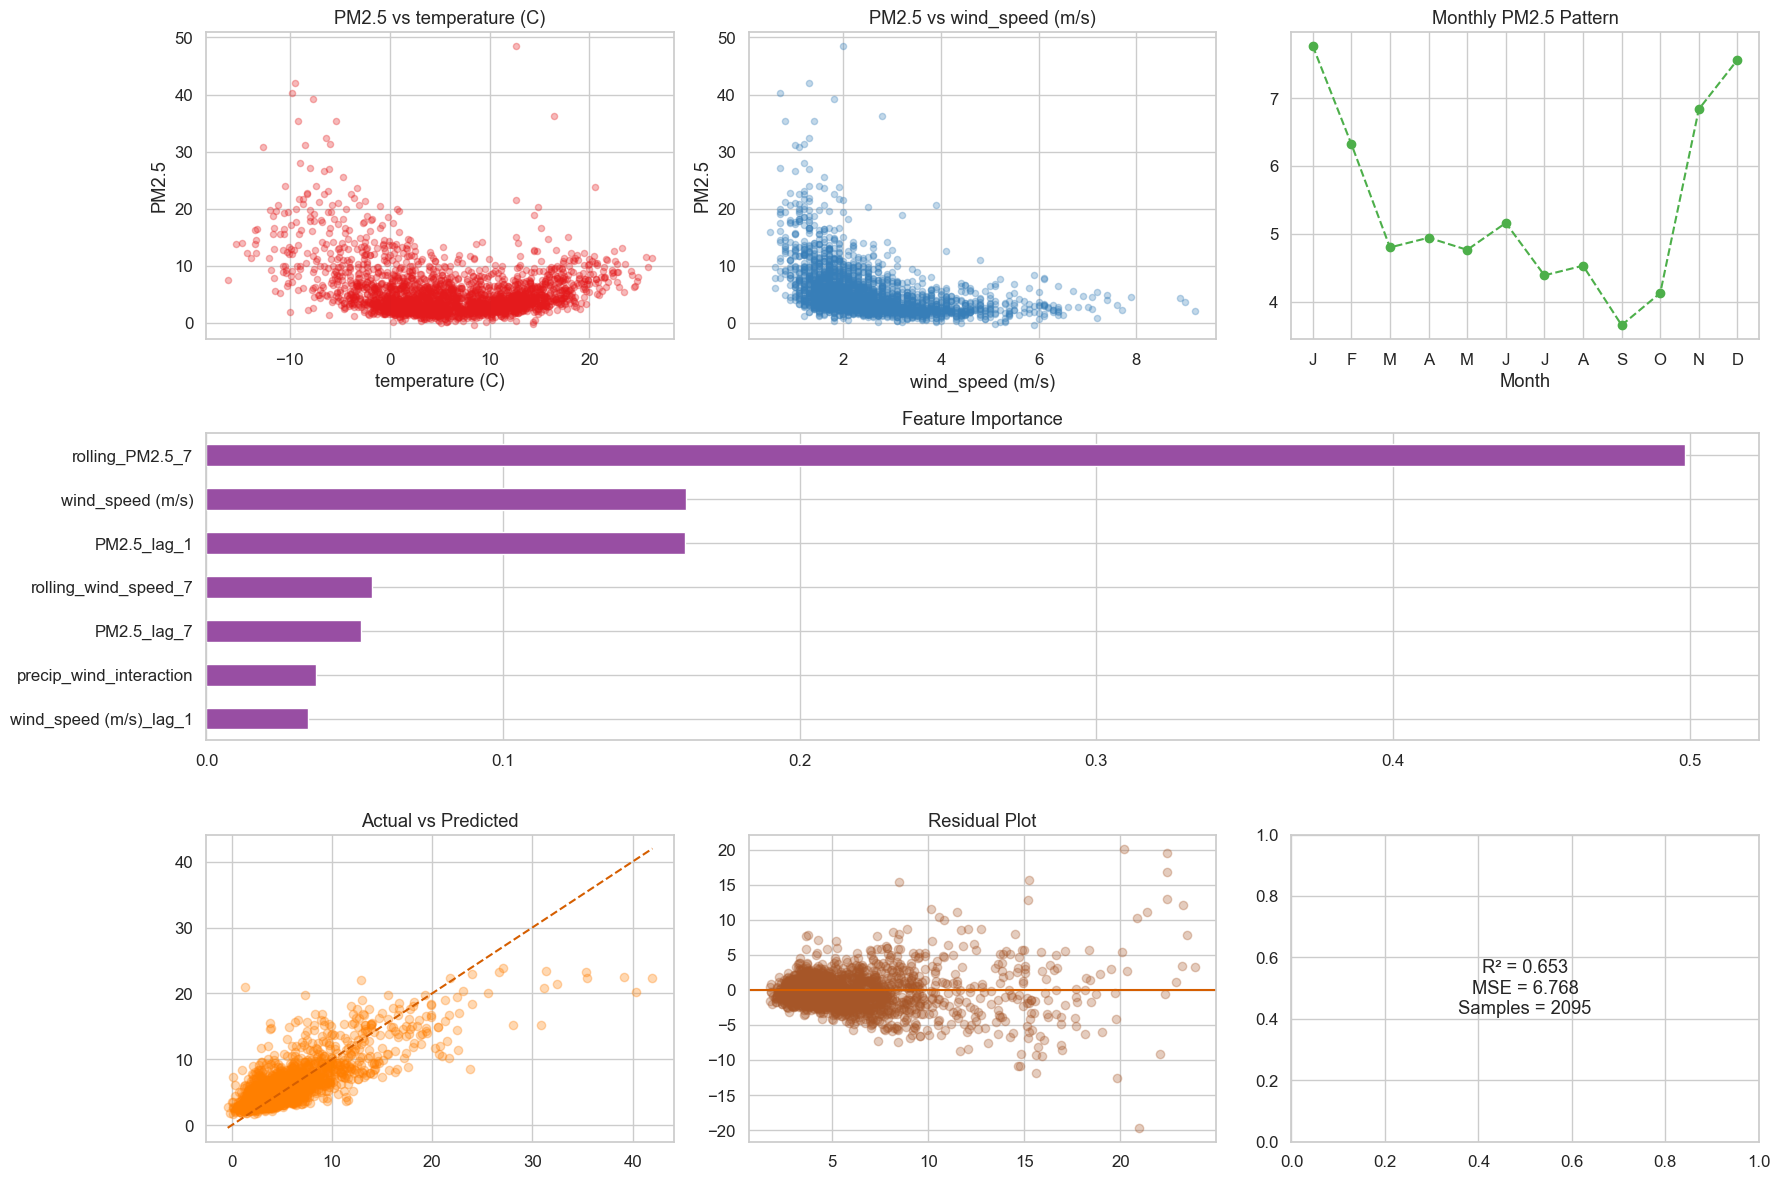

In [7]:
# ------------------------------------------
# MODEL EVALUATION & FORECASTING
# ------------------------------------------

# -- simple weather model predictions using only 'DayOfYear' --
last_historical_date = weather_train['Date'].max()
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
test_period_end = df_forecast['Date'].max()
days_to_predict = (test_period_end - last_historical_date).days

temp_forecast = predicted_data.predict_future(
    model_temp,
    last_historical_date,
    days_to_predict  
)
precip_forecast = predicted_data.predict_future(
    model_precip,
    last_historical_date,
    days_to_predict  
)
wind_forecast = predicted_data.predict_future(
    model_wind,
    last_historical_date,
    days_to_predict  
)

# -- Create prediction for pollutants based on the weather forecast --

# Preparing weather forecast and historical data
historical_data = merged_data_test.sort_values('Date').tail(30).copy()
forecast_weather = df_forecast.copy()

# Run the forecasting
if df_forecast.empty:
    print("⚠️ No forecast data available - skipping pollutant forecasts")
    pollutant_forecasts = None
else:
    pollutant_forecasts = predicted_data.forecast_pollutants_with_lags(
        df_forecast, 
        models_dict={
            'NO': no_model,
            'NO2': no2_model,
            'PM2.5': pm25_model,
            'PM10': pm10_model
        },
        features_dict={
            'NO': NO_FEATURES,
            'NO2': NO2_FEATURES,
            'PM2.5': PM25_FEATURES,
            'PM10': PM10_FEATURES
        },
        historical_data=historical_data,
        n_days=7 
    )

# --- Show information about the models ---

# Visual information about the models
if SHOW_ALL_GRAPHS:
    for pol in POLLUTANT_VARS:
        try:

            if pol not in pollutant_data_sources or pol not in pollutant_features:
                        print(f"Skipping {pol} - no data or features defined")
                        continue
            
            predictive_graphs.model_information(
                model=pollutant_models[pol],
                merged_data=pollutant_data_sources[pol],
                weather_vars=WEATHER_VARS,
                target=pol,
                features=pollutant_features[pol]
            )
            
        except Exception as e:
            print(f"Error analyzing {pol}: {str(e)}")
            continue

else:
    try: 
        predictive_graphs.model_information(
            model=pm25_model,
            merged_data=merged_data_test,
            weather_vars=WEATHER_VARS,
            target='PM2.5',
            features=PM25_FEATURES
        )
    except Exception as e:
        print(f"Error showing default visualization: {str(e)}")

# The following block of code was suggested and refined by AI
    # Purpose: Reducing reduntant lines to a help function
    # AI Tool: DeepSeek

# Showing tables of the worst prediction dates for each pollutant
def show_worst_cases(df, pollutant, features):
    '''A helper tool to produce repeated tables of worst predictions'''
    worst = df.nlargest(5, f'{pollutant}_error')[['Date', pollutant, 'Prediction', f'{pollutant}_error'] + features]
    worst['Date'] = worst['Date'].dt.date
    print(f"\n{pollutant} Worst Cases:")
    pretty_table.pretty_data(worst)

if SHOW_ALL_TABLES:
    show_worst_cases(co_test, 'CO', CO_FEATURES)
    show_worst_cases(no_test, 'NO', NO_FEATURES)
    show_worst_cases(no2_test, 'NO2', NO2_FEATURES)
    show_worst_cases(pm25_test, 'PM2.5', PM25_FEATURES)
    show_worst_cases(pm10_test, 'PM10', PM10_FEATURES)

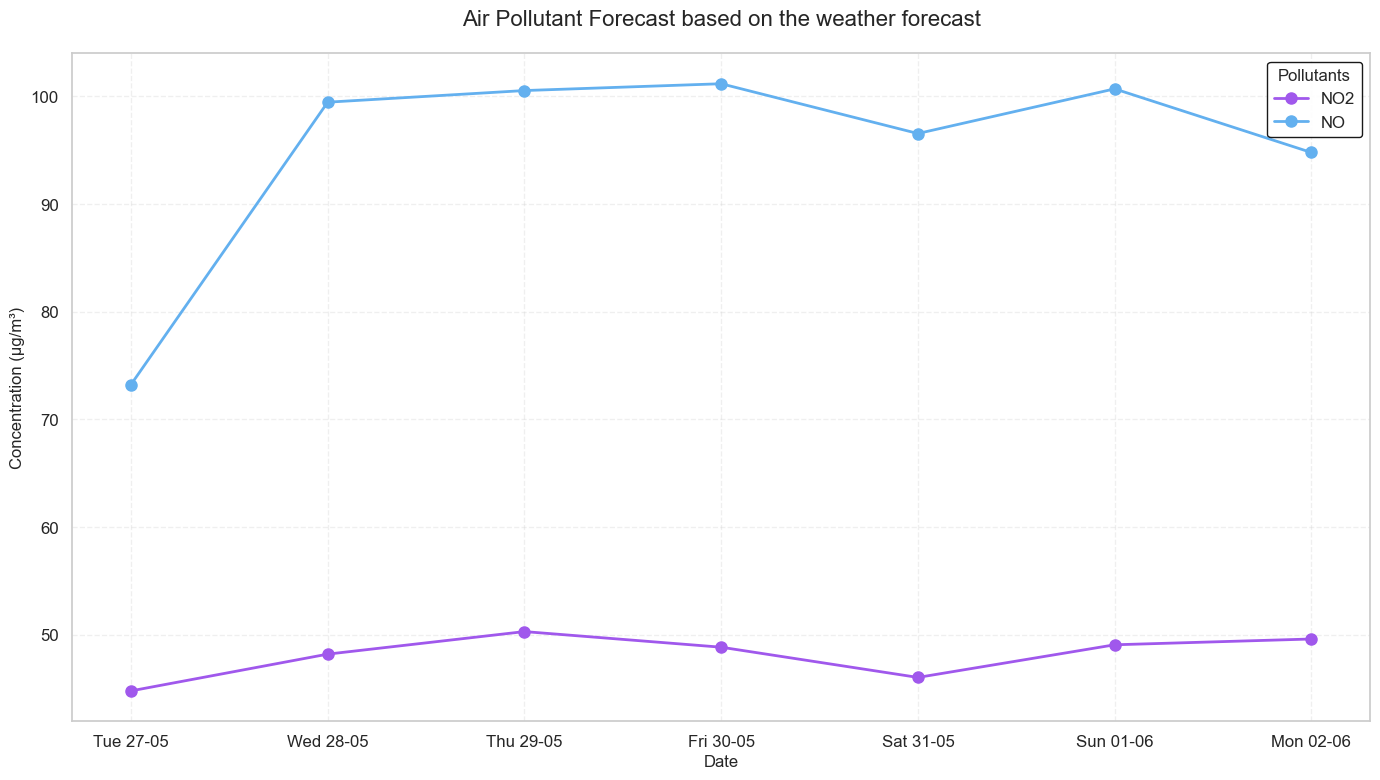

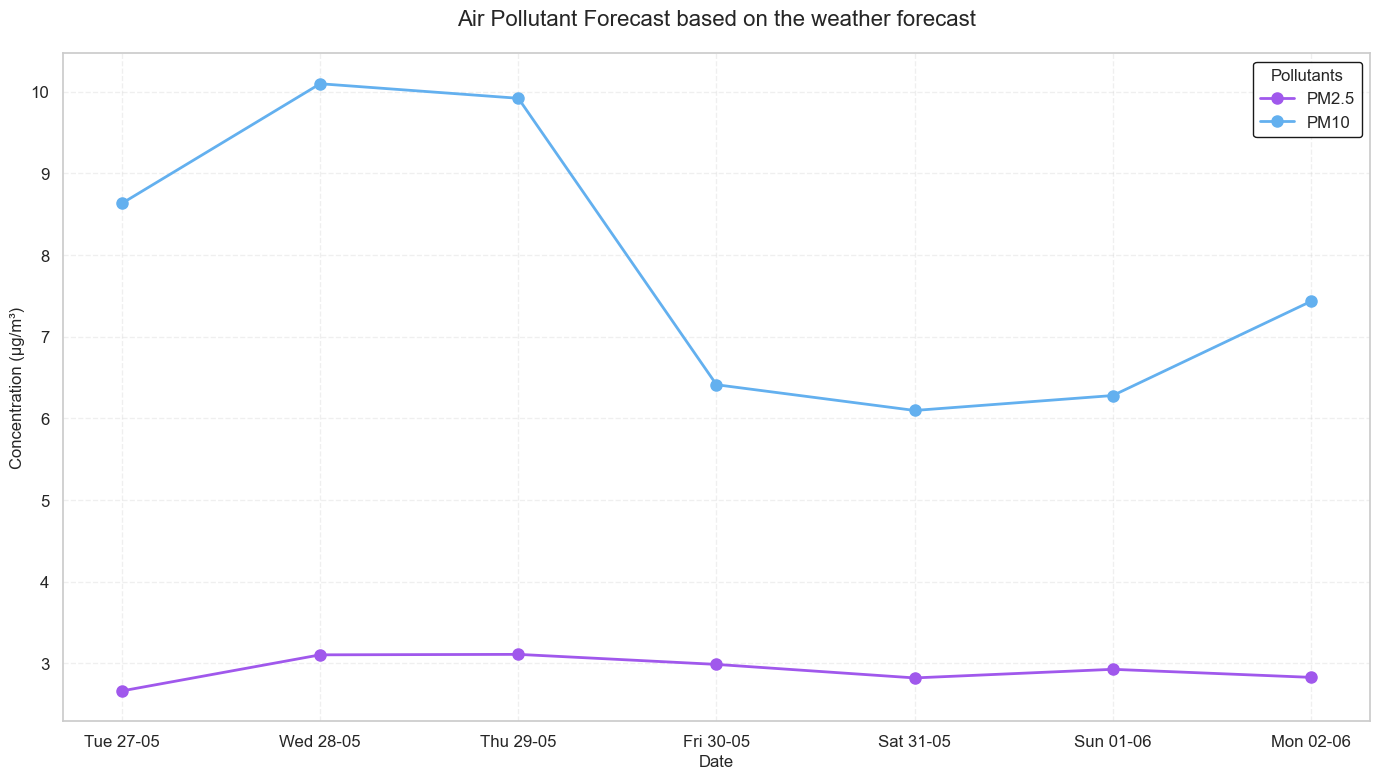

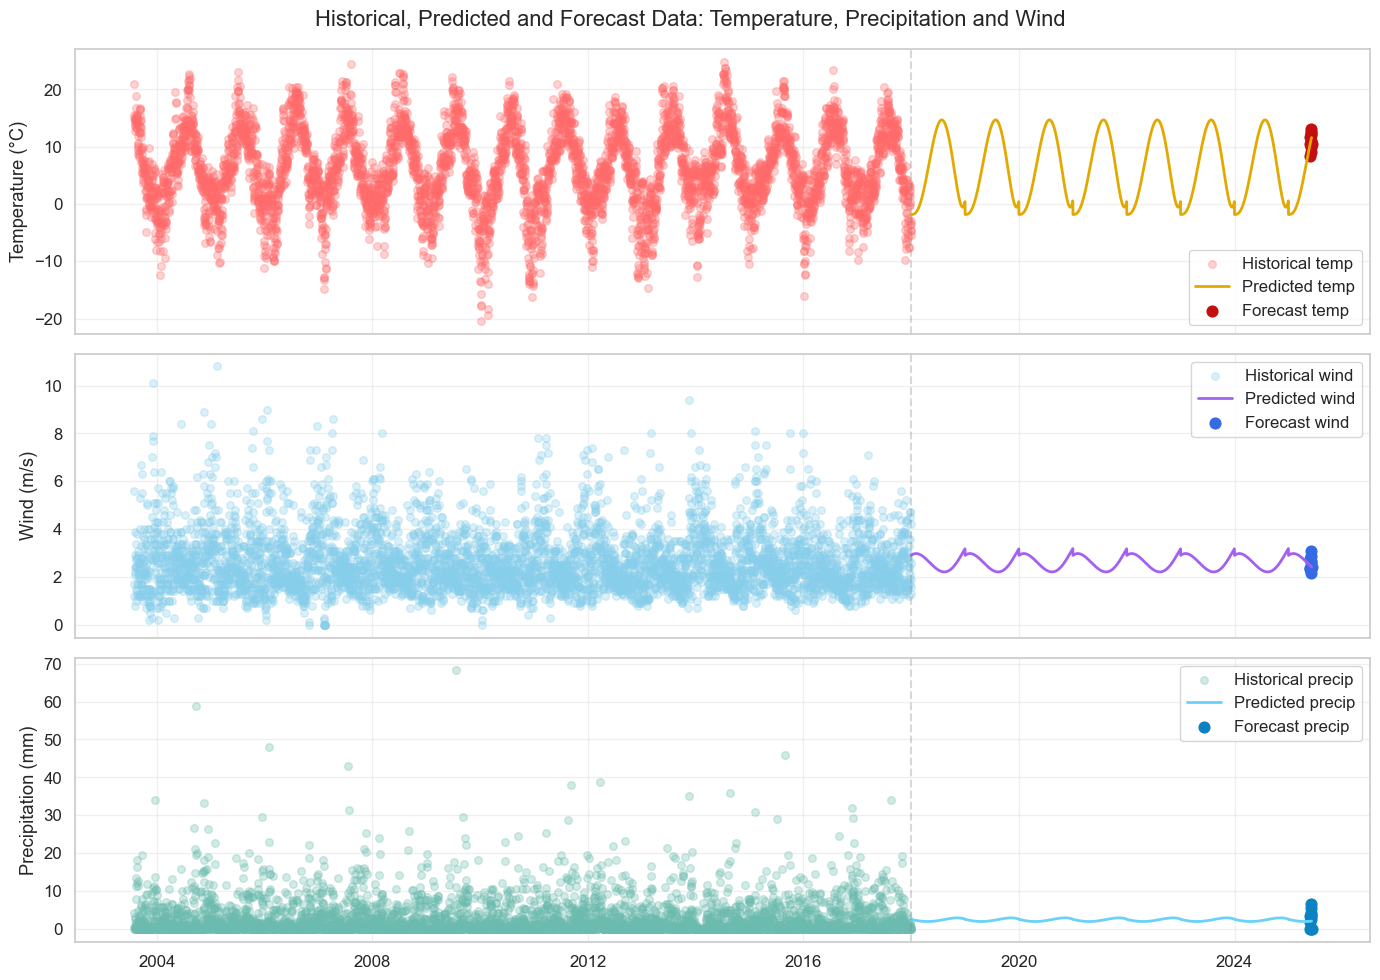

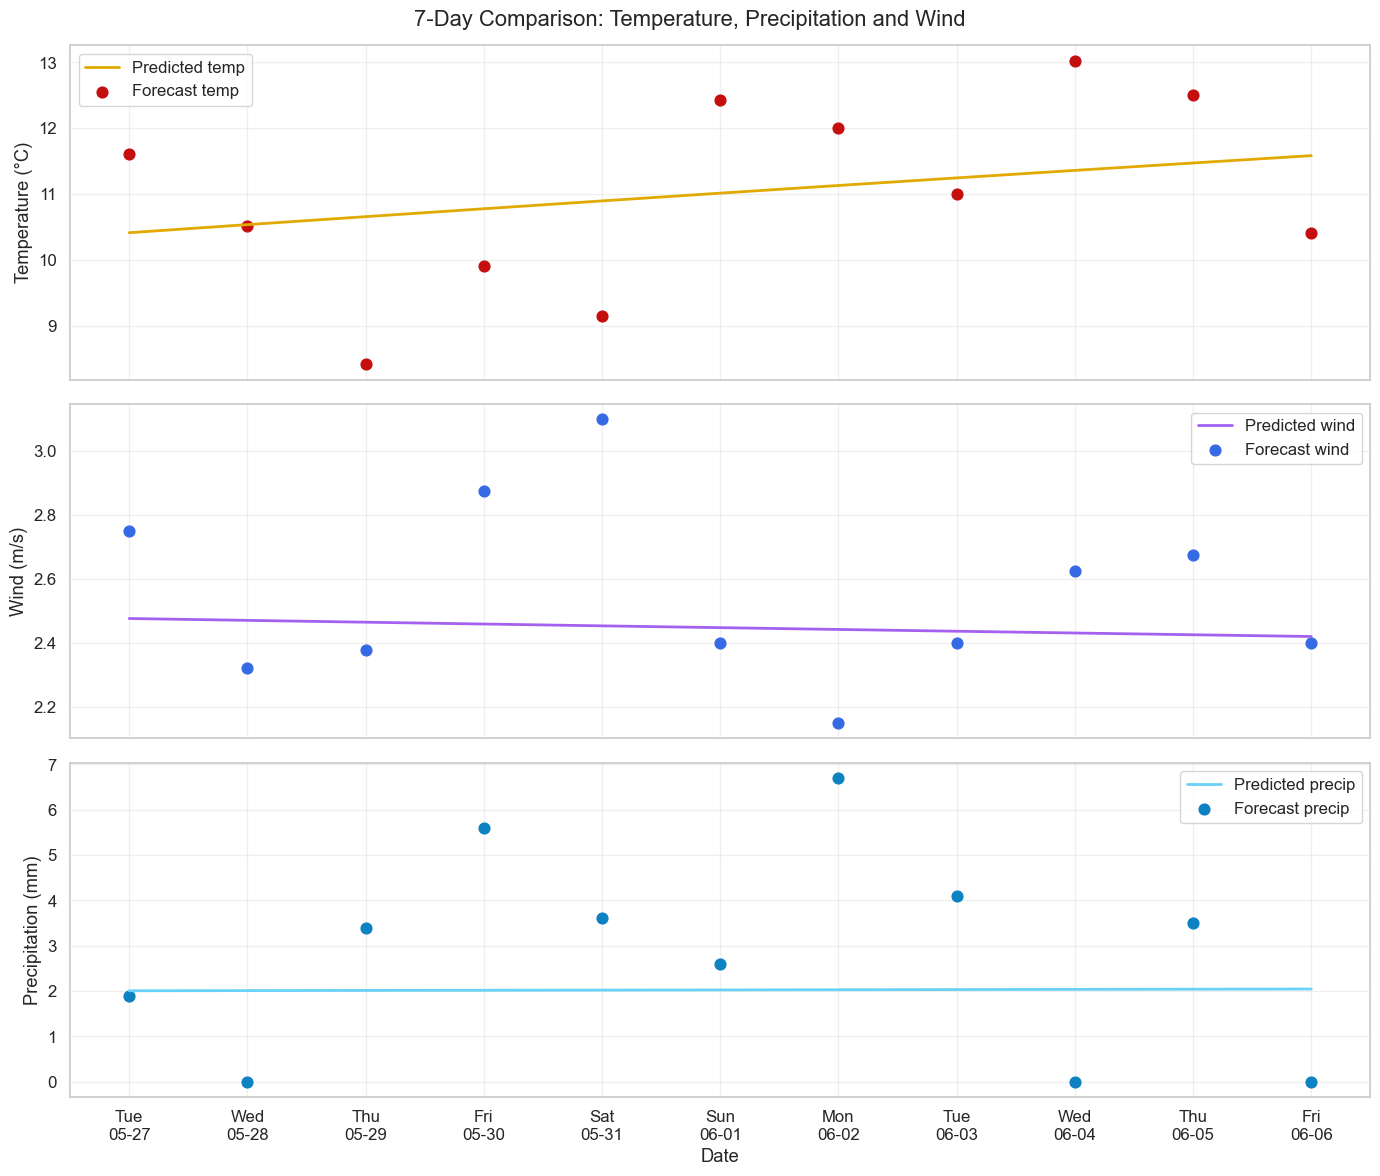

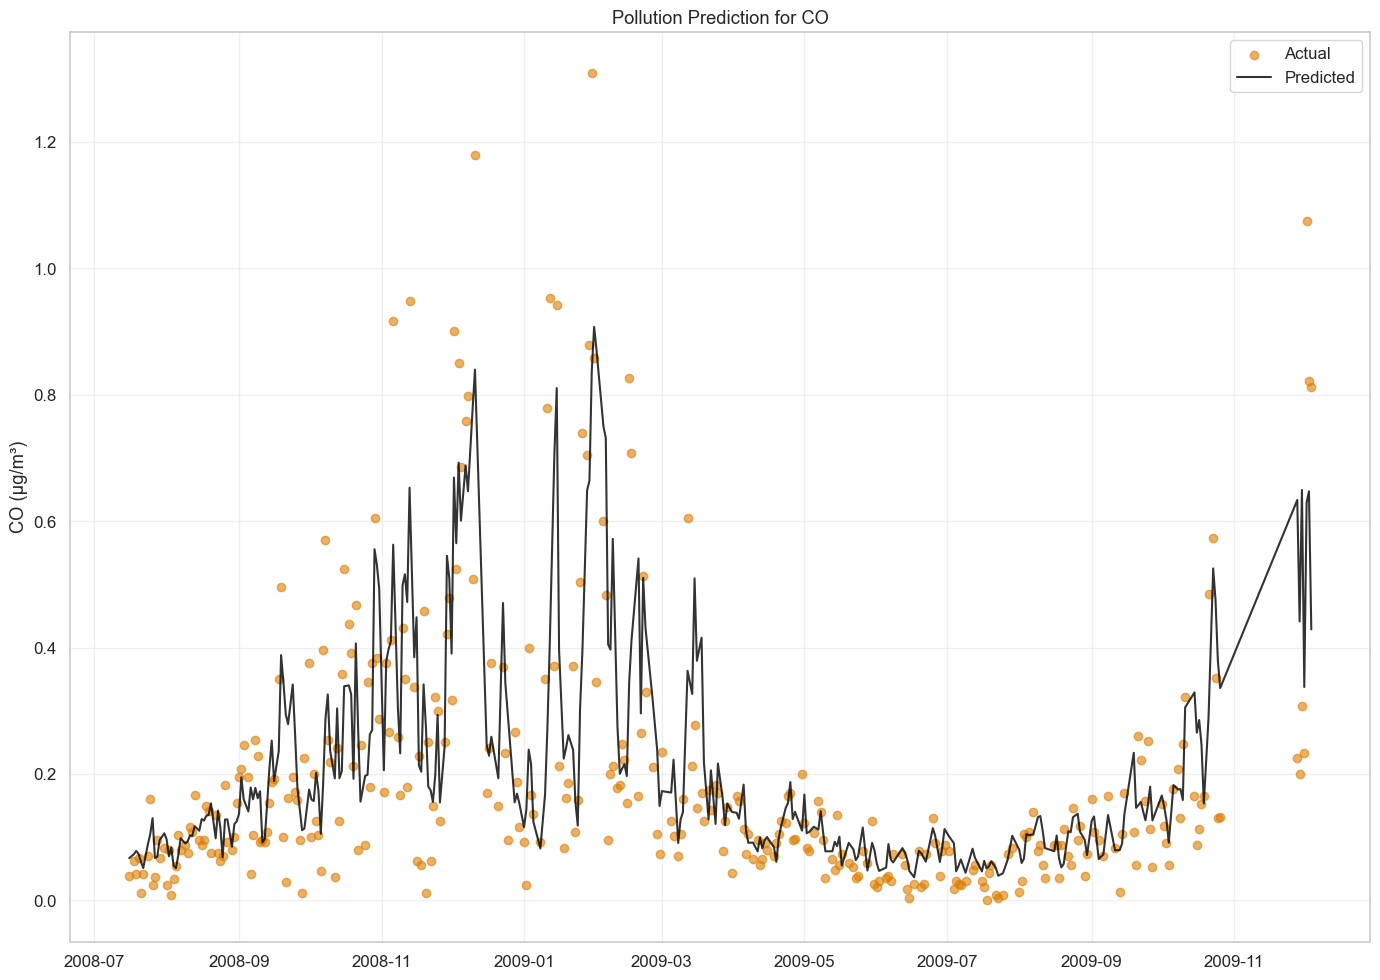

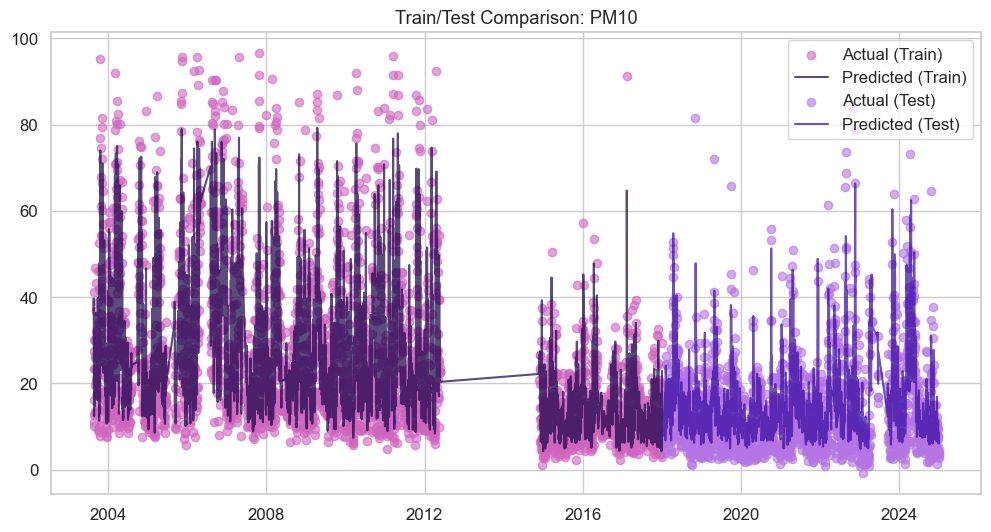

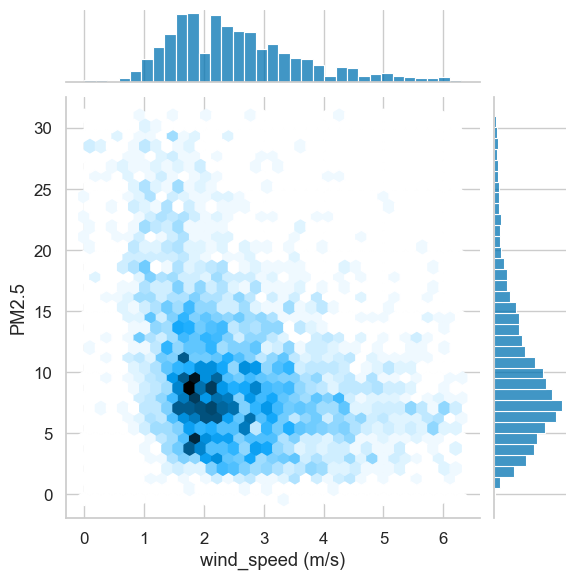

In [8]:
# ------------------------------------------
# GRAPHING OF PREDICTIVE ANALYSIS
# ------------------------------------------

# Pollutant forecast based on weather forecast
if pollutant_forecasts is not None:
    predictive_graphs.plot_pollutant_forecasts(
        pollutant_forecasts,
        pollutants=['NO2', 'NO'] 
    )
    predictive_graphs.plot_pollutant_forecasts(
        pollutant_forecasts,
        pollutants=['PM2.5', 'PM10'] 
    )
else:
    print("⚠️ No pollutant forecasts to visualize")

# Graph of weather data: historical, modelled, and predicted
predictive_graphs.plot_full_overview(
    historical_df=weather_train,
    forecast_temp=temp_forecast, 
    forecast_precip=precip_forecast,
    forecast_wind=wind_forecast,
    api_df=df_forecast
)

# Graph of the weather foreast with the model
predictive_graphs.plot_week_comparison(
    temp_forecast, 
    precip_forecast, 
    wind_forecast, 
    df_forecast)

# Comparison of the modelled values and the actual test values
predictive_graphs.plot_results(co_test, 'CO')
if SHOW_ALL_GRAPHS:
    predictive_graphs.plot_results(no_test, 'NO')
    predictive_graphs.plot_results(no2_test, 'NO2')
    predictive_graphs.plot_results(pm25_test, 'PM2.5')
    predictive_graphs.plot_results(pm10_test, 'PM10')

# Comparison of model accuracy between training data and test data
if SHOW_ALL_GRAPHS:
    predictive_graphs.plot_comparison(co_train, co_test, 'CO')
    predictive_graphs.plot_comparison(no_train, no_test, 'NO')
    predictive_graphs.plot_comparison(no2_train, no2_test, 'NO2')
    predictive_graphs.plot_comparison(pm25_train, pm25_test, 'PM2.5')
predictive_graphs.plot_comparison(pm10_train, pm10_test, 'PM10')

# Hexbin plots for density visualisation
if SHOW_ALL_GRAPHS:
    for col in [v for v in WEATHER_VARS if v != 'Date']:
        for pol in POLLUTANT_VARS:
            try:
                sns.jointplot(data=merged_data, x=col, y=pol, kind='hex')
            except Exception as e:
                print(f"Could not plot {col} vs {pol}: {str(e)}")
else:
    sns.jointplot(data=merged_data, x='wind_speed (m/s)', y='PM2.5', kind='hex')


In [9]:
# ------------------------------------------
# INTERACTIVE DATA VISUALIZATION - TRIAL
# ------------------------------------------
import plotly.io as pio
pio.renderers.default = "notebook_connected" 

from graph_test import InteractiveGraphs
ig = InteractiveGraphs(weather_vars=WEATHER_VARS)

# Daily pollution (toggle pollutants)
ig.dot_graph(df_quality, POLLUTANTS, 'Air pollution (Daily)', 'Date', 'Concentration (µg/m³)')

# Weekly pollution (toggle pollutants)
ig.dot_graph(df_average_pollutants, POLLUTANTS, 'Air pollution (Weekly)', 'Date', 'Concentration (µg/m³)')

if SHOW_ALL_GRAPHS is True:
    warning_msg = """
    ---------------------------------
    WARNING: Experimental Feature
    ---------------------------------
    The comparative graph below is still
    in development. Some interactions
    may not work as expected.
    """
    print(warning_msg)

    # Comparative graphs 
    ig.comparative_graph(
        df=df_quality,
        columns=POLLUTANTS,
        df_predictor=df_weather,
        predictor=WEATHER_VARS[0], 
        title='Pollution vs Weather',
        x_axis='Date',
        y_axis='Pollution (µg/m³)',
        y_lims=WEATHER_Y_LIMS[0], 
        zero_align=False
    )

In [10]:
# ------------------------------------------
# SAVE DATA TO FILE
# ------------------------------------------

# The following block of code was written with assistance from AI
    # - Purpose: AI was used to help pinpoint the correct folder location.
    # - AI Tool: DeepSeek

if SAVE_FILE:
    print("\nSaving analysis results to files...")
    
    try:        
        # Core(historical) datasets
        version = datetime.datetime.now().strftime("%Y%m%d")
        os.makedirs('../data', exist_ok=True)
        
        # Test datasets  
        df_weather.to_csv(f'../data/refined_weather_data_{version}.csv', 
                         encoding='utf-8', index=False)
        df_quality.to_csv(f'../data/refined_air_quality_data_{version}.csv',
                         encoding='utf-8', index=False)
        
        # Test datasets with versioning  
        df_weather_test.to_csv(f'../data/refined_weather_test_data_{version}.csv',
                             encoding='utf-8', index=False)
        df_quality_test.to_csv(f'../data/refined_air_quality_test_data_{version}.csv',
                             encoding='utf-8', index=False)
        
        # Historical data without outliers
        weather_x_outliers.to_csv(f'../data/cleaned_weather_data_{version}.csv',
                                encoding='utf-8', index=False)
        pollution_x_outliers.to_csv(f'../data/cleaned_air_quality_data_{version}.csv',
                                  encoding='utf-8', index=False)
        
        # Weather forecast
        if df_forecast is not None:
            df_forecast.to_csv(f'../data/weather_forecast_{version}.csv',
                             encoding='utf-8', index=False)
        
        # Pollutant forecast
        if pollutant_forecasts is not None:
            if isinstance(pollutant_forecasts, dict):

                # Combine all pollutant forecasts into one DataFrame
                combined_forecasts = pd.concat(
                    [df.assign(Pollutant=pol) 
                     for pol, df in pollutant_forecasts.items() 
                     if hasattr(df, 'to_csv')],
                    ignore_index=True
                )
                combined_forecasts.to_csv(
                    f'../data/combined_pollutant_forecasts_{version}.csv',
                    encoding='utf-8',
                    index=False
                )
            elif hasattr(pollutant_forecasts, 'to_csv'):
                # If it's already a single DataFrame
                pollutant_forecasts.to_csv(
                    f'../data/pollutant_forecasts_{version}.csv',
                    encoding='utf-8',
                    index=False
                )
        
        # Model results
        co_test.to_csv(f'../data/model_results_co_{version}.csv',
                      encoding='utf-8', index=False)
        no_test.to_csv(f'../data/model_results_no_{version}.csv',
                      encoding='utf-8', index=False)
        no2_test.to_csv(f'../data/model_results_no2_{version}.csv',
                       encoding='utf-8', index=False)
        pm25_test.to_csv(f'../data/model_results_pm25_{version}.csv',
                        encoding='utf-8', index=False)
        pm10_test.to_csv(f'../data/model_results_pm10_{version}.csv',
                        encoding='utf-8', index=False)
        
        print(f"✅ Save complete! Files include version suffix: {version}")
        print("Check the ../data/ directory for files.")
        
    except Exception as e:
        print(f"⚠️ Error during file saving: {str(e)}")